# 施設名称のTF-IDF (ngram) ＋ 施設名称のTF-IDF (word) ＋ 駅の近さ ＋ 施設名称中の数値

---

## セットアップ

### モジュールのインポート

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 500)

# グラフ描画
from matplotlib import pyplot as plt
import japanize_matplotlib

# 前処理
## 施設名称のTF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA

# モデルの学習と評価
from sklearn.model_selection import KFold
from optuna.integration import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# モデルの解釈
import shap
shap.initjs()
# SHAPがmatplotlibの古いAPIを使っているせいでグラフ描画時に警告が出るため、SHAP関連の警告を非表示にする
import warnings
warnings.filterwarnings("ignore", module = "shap\..*")

### データのインポート

In [2]:
# 学習データ
train = pd.read_csv("./data/train_data.csv")
train["last_review"] = pd.to_datetime(train["last_review"])
train.set_index("id", inplace = True)

In [3]:
# テストデータ
test = pd.read_csv("./data/test_data.csv")
test["last_review"] = pd.to_datetime(test["last_review"])
test.set_index("id", inplace = True)

In [4]:
# 駅リスト
station_list = pd.read_csv("data/station_list.csv")
station_list["station_name"] = (
    station_list["station_name"] + " (" +
    station_list["longitude"].astype(str).str.slice(0, 10) + ", " +
    station_list["latitude"].astype(str).str.slice(0, 9) + ")"
)

---

## 前処理

### 施設名称のTF-IDF

In [5]:
def add_tfidf_ngram(train, test):
    ngram_range = (1, 4)
    n_components = 100

    # TF-IDF
    names = pd.concat([train["name"], test["name"]], ignore_index = True)
    names = names.str.replace(r"\s", "", regex = True)
    names = names.str.replace(r"\d", "0", regex = True)
    vectorizer = TfidfVectorizer(analyzer = "char", ngram_range = ngram_range)
    names = vectorizer.fit_transform(names)

    # SVD
    svd = TruncatedSVD(n_components = n_components, random_state = 0)
    names = svd.fit_transform(names)
    names = pd.DataFrame(names, columns = [f"tfidf_ngram_svd_{i:02d}" for i in range(n_components)])

    # 施設名称のTF-IDFを学習データとテストデータに追加する
    names_train = names.iloc[:train.shape[0], :].copy()
    names_train.index = train.index
    train = train.merge(names_train, how = "left", on = "id")
    names_test = names.iloc[train.shape[0]:, :].copy()
    names_test.index = test.index
    test = test.merge(names_test, how = "left", on = "id")

    return train, test

In [6]:
def add_tfidf_word(train, test):
    n_components = 100

    # TF-IDF
    names = pd.concat([train["name"], test["name"]], ignore_index = True)
    names = names.str.replace(r"\d", "0", regex = True)
    vectorizer = TfidfVectorizer()
    names = vectorizer.fit_transform(names)

    # SVD
    svd = TruncatedSVD(n_components = n_components, random_state = 0)
    names = svd.fit_transform(names)
    names = pd.DataFrame(names, columns = [f"tfidf_word_svd_{i:02d}" for i in range(n_components)])

    # 施設名称のTF-IDFを学習データとテストデータに追加する
    names_train = names.iloc[:train.shape[0], :].copy()
    names_train.index = train.index
    train = train.merge(names_train, how = "left", on = "id")
    names_test = names.iloc[train.shape[0]:, :].copy()
    names_test.index = test.index
    test = test.merge(names_test, how = "left", on = "id")

    return train, test

In [7]:
train, test = add_tfidf_ngram(train, test)
train, test = add_tfidf_word(train, test)

### 駅の近さ

In [8]:
# 駅の近さを求める
def calc_dist_station(train, test):
    traintest = pd.concat([
        train.reset_index().assign(usage = "train"),
        test.reset_index().assign(usage = "test")
    ], ignore_index = True)

    # 施設と駅の直積を作る
    station_dist = pd.merge(
        traintest[["usage", "id", "latitude", "longitude"]].assign(key = 0),
        station_list.assign(key = 0),
        how = "left",
        on = "key"
    )

    # 駅からの距離 (km)
    # 緯度差40分≒経度差1度(＝60分)≒80km と仮定して計算する
    station_dist["d"] = np.sqrt(
        (station_dist["latitude_x"] * 1.5 - station_dist["latitude_y"] * 1.5) ** 2 +
        (station_dist["longitude_x"] - station_dist["longitude_y"]) ** 2
    ) * 80

    # 駅の近さ
    # 駅から1km圏内にあれば1に近く、圏外にあれば0に近くなる
    station_dist["s"] = np.exp(-0.5 * (station_dist["d"] ** 2))

    return station_dist

In [9]:
def add_sta_s(train, test):
    n_components = 50

    # 駅の近さを求める
    station_dist = calc_dist_station(train, test)

    # 横持ちに変換する
    station_dist = station_dist.pivot(index = ["usage", "id"], columns = "station_name", values = "s")

    # 次元削減
    pca = PCA(
        n_components = n_components,
        whiten = True,
        svd_solver = "randomized",
        random_state = 0
    )
    pca = pca.fit(station_dist)
    station_dist_pca = pd.DataFrame(
        pca.transform(station_dist),
        index = station_dist.index,
        columns = [f"sta_s_pca_{i:02d}" for i in range(n_components)]
    )
    station_dist_pca = station_dist_pca.reset_index()

    train = (
        train.merge((
            station_dist_pca.
            loc[lambda df: df["usage"] == "train", :].
            drop(columns = ["usage"]).
            set_index("id")
        ), how = "left", on = "id")
    )
    test = (
        test.merge((
            station_dist_pca.
            loc[lambda df: df["usage"] == "test", :].
            drop(columns = ["usage"]).
            set_index("id")
        ), how = "left", on = "id")
    )

    return train, test

In [10]:
train, test = add_sta_s(train, test)

### 施設名称に含まれる各種数値

In [11]:
def extract_num(data):
    data = (
        data.
        assign(name_lower = lambda df: df["name"].str.lower()).
        # 最大人数
        assign(guests = lambda df: df["name_lower"].str.extract(r"(\d+)\W*guests?")[0].astype(float)).
        assign(guests = lambda df: df["guests"].mask(df["guests"].isna(), df["name_lower"].str.extract(r"(\d+)\W*people")[0].astype(float))).
        assign(guests = lambda df: df["guests"].mask(df["guests"].isna(), df["name_lower"].str.extract(r"(\d+)\W*ppl")[0].astype(float))).
        assign(guests = lambda df: df["guests"].mask(df["guests"].isna(), df["name_lower"].str.extract(r"(\d+)\W*pax")[0].astype(float))).
        assign(guests = lambda df: df["guests"].mask(df["guests"].isna(), df["name_lower"].str.extract(r"(\d+)人")[0].astype(float))).
        assign(guests = lambda df: df["guests"].mask(df["guests"].isna(), df["name_lower"].str.extract(r"(\d+)名")[0].astype(float))).
        assign(guests = lambda df: df["guests"].mask(df["guests"].isna(), df["name_lower"].str.extract(r"max\W*(\d+)")[0].astype(float))).
        assign(guests = lambda df: df["guests"].mask(df["guests"].isna(), df["name_lower"].str.extract(r"pax\W*(\d+)")[0].astype(float))).
        assign(guests = lambda df: df["guests"].mask(df["guests"].isna(), df["name_lower"].str.extract(r"最大(\d+)")[0].astype(float))).
        # ベッド数
        assign(beds = lambda df: df["name_lower"].str.extract(r"(\d+)\W*beds?")[0].astype(float)).
        assign(beds = lambda df: df["beds"].mask(df["beds"].isna(), df["name_lower"].str.extract(r"(\d+)\W*br")[0].astype(float))).
        # 駅までの時間
        assign(mins = lambda df: df["name_lower"].str.extract(r"(\d+)\W*mins?")[0].astype(float)).
        assign(mins = lambda df: df["mins"].mask(df["mins"].isna(), df["name_lower"].str.extract(r"(\d+)分")[0].astype(float))).
        # 広さ
        assign(sqm = lambda df: df["name_lower"].str.extract(r"(\d+)\W*㎡")[0].astype(float)).
        assign(sqm = lambda df: df["sqm"].mask(df["sqm"].isna(), df["name_lower"].str.extract(r"(\d+)\W*sqm")[0].astype(float))).
        assign(sqm = lambda df: df["sqm"].mask(df["sqm"].isna(), df["name_lower"].str.extract(r"(\d+)\W*m2")[0].astype(float))).
        assign(sqm = lambda df: df["sqm"].mask(df["sqm"].isna(), df["name_lower"].str.extract(r"(\d+)\W*平米")[0].astype(float)))
    )

    return data

In [12]:
train = extract_num(train)
test = extract_num(test)

### その他

In [13]:
def preprocess(data):
    data = data.copy()

    # 説明変数として使う列を取り出す
    data = data[
        [
            "neighbourhood",
            "latitude",
            "longitude",
            "room_type",
            "minimum_nights",
            "number_of_reviews",  # 欠損値あり
            "reviews_per_month",
            "availability_365",
            "guests",  # 欠損値あり
            "beds",    # 欠損値あり
            "mins",    # 欠損値あり
            "sqm",     # 欠損値あり
        ] +
        data.columns[data.columns.str.startswith("tfidf_ngram_svd_")].tolist() +
        data.columns[data.columns.str.startswith("tfidf_word_svd_")].tolist() +
        data.columns[data.columns.str.startswith("sta_s_pca_")].tolist()
    ].copy()

    # カテゴリー変数の型をcategoryにする
    # こうすることで、LightGBMがカテゴリー変数として認識してくれるようになる
    data["neighbourhood"] = data["neighbourhood"].astype("category")
    data["room_type"] = data["room_type"].astype("category")

    return data

In [14]:
# 説明変数
train_x = preprocess(train)
test_x = preprocess(test)

# 目的変数
# 評価指標がRMSLEのため、あらかじめ目的変数に対数変換を施しておく
train_y = np.log1p(train["y"])

---

## 学習と予測

### 学習 (交差検定)

In [15]:
cv = lgb.LightGBMTunerCV(
    params = {
        "objective": "regression",
        "deterministic": True,
        "verbosity": -1,
        "metric": "rmse"
    },
    train_set = lgb.Dataset(train_x, label = train_y),
    num_boost_round = 1000,
    folds = KFold(n_splits = 5, random_state = 0, shuffle = True),
    seed = 0,
    return_cvbooster = True,
    optuna_seed = 0,
    verbose_eval = None
)
cv.run()

model = cv.get_best_booster()

[I 2022-05-06 10:55:27,921] A new study created in memory with name: no-name-40682d62-48f7-4255-a62e-a910785ab307
min_data_in_leaf, val_score: 0.501130: 100%|##########| 5/5 [01:24<00:00, 16.99s/it]


In [16]:
cv.best_params

{'objective': 'regression',
 'deterministic': True,
 'verbosity': -1,
 'metric': 'rmse',
 'feature_pre_filter': False,
 'lambda_l1': 2.471598727553709e-07,
 'lambda_l2': 7.067019500748873e-07,
 'num_leaves': 31,
 'feature_fraction': 0.5,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

In [17]:
cv.best_score

0.5011299940097748

### 予測

In [18]:
# 交差検定の各モデルで予測した結果をアンサンブルしたものを、最終的な予測結果とする
submission = pd.DataFrame({
    "id": test_x.index,
    "y": np.expm1(np.array(model.predict(test_x)).mean(axis = 0))
})

In [19]:
submission.to_csv("./submit/submission.csv", index = False, header = True)

---

## モデルの解釈

### SHAP値 > 特徴量重要度

In [20]:
explainer = shap.TreeExplainer(model.boosters[0])
shap_values = explainer(train_x.apply(lambda column: column.cat.codes if column.dtype.name == "category" else column))
shap_values.display_data = train_x.values

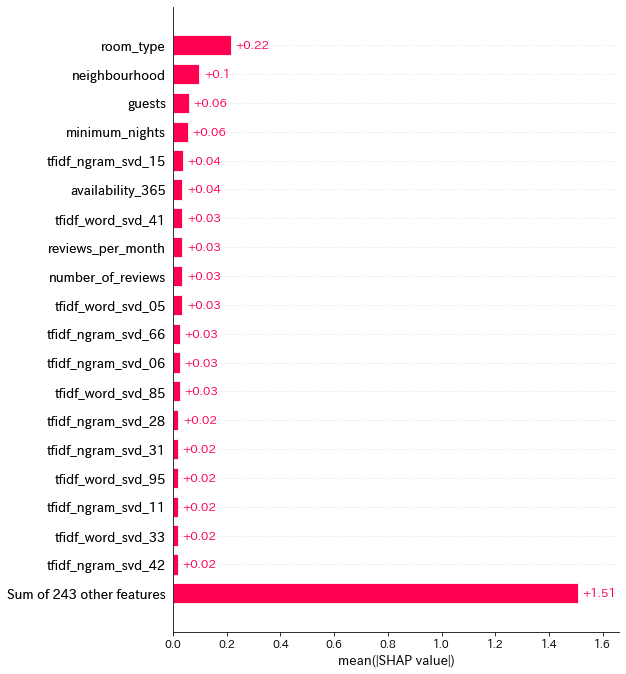

In [21]:
shap.plots.bar(shap_values, max_display = 20)

### SHAP値 > 説明変数×SHAP値の散布図

neighbourhood


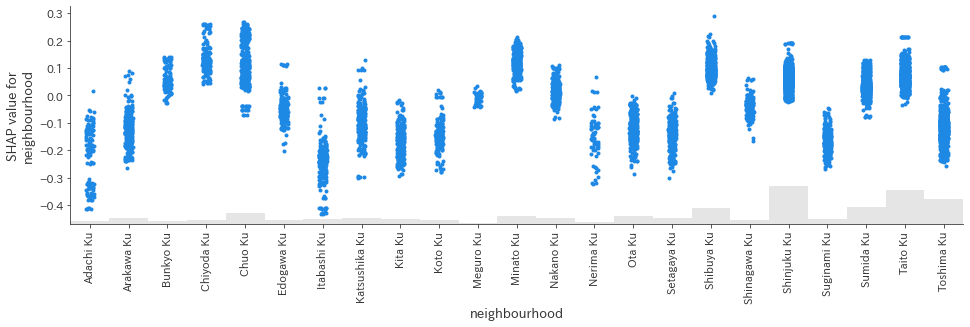

latitude


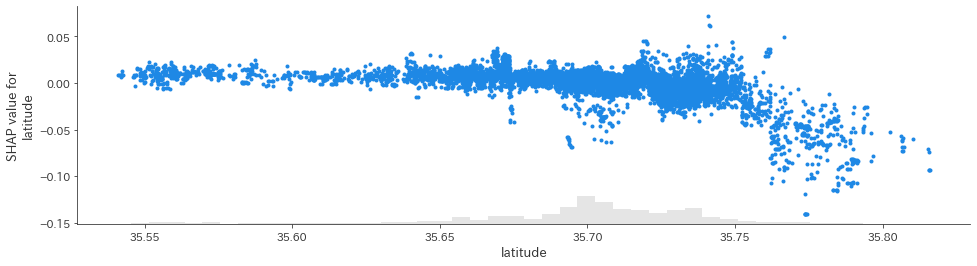

longitude


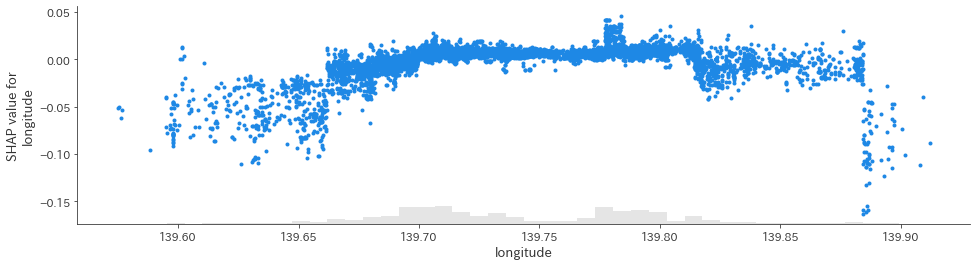

room_type


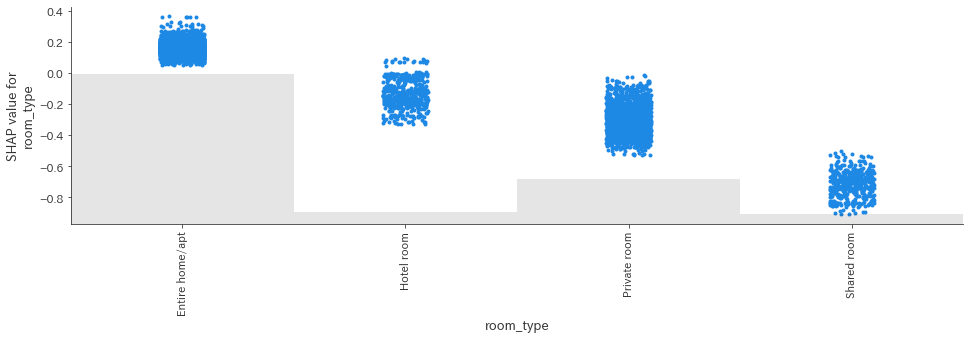

minimum_nights


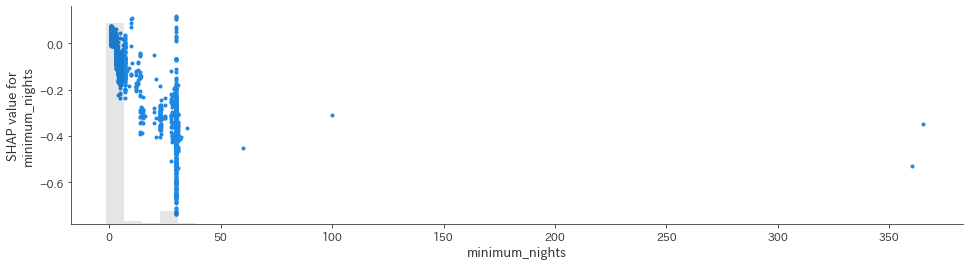

number_of_reviews


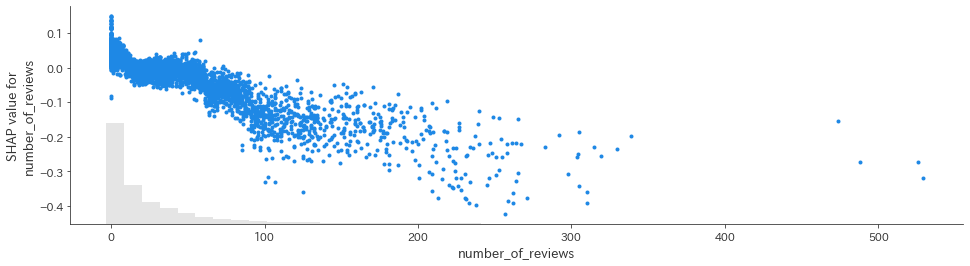

reviews_per_month


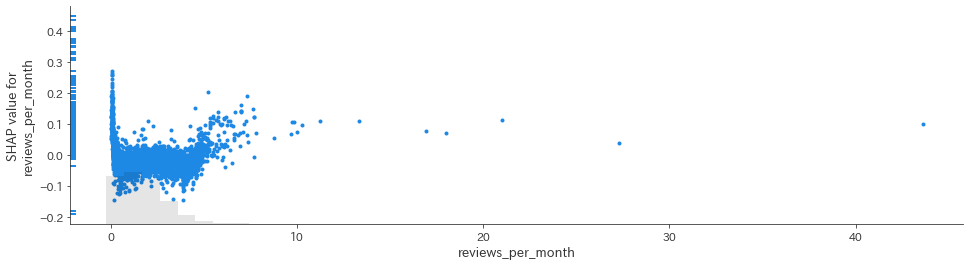

availability_365


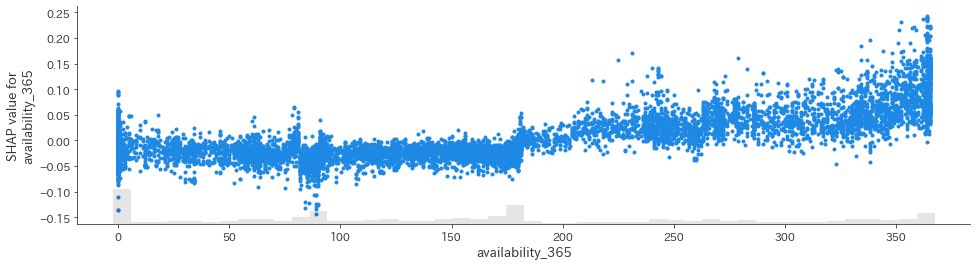

guests


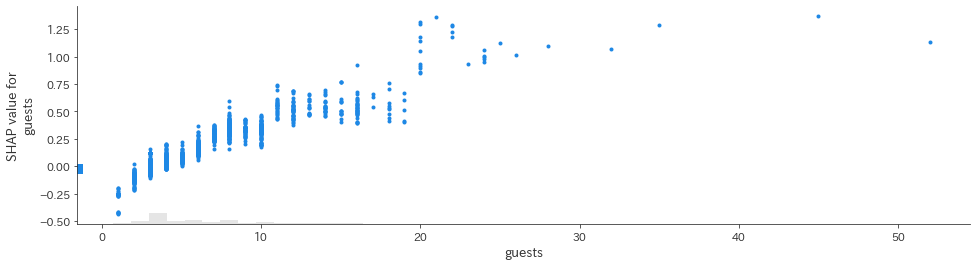

beds


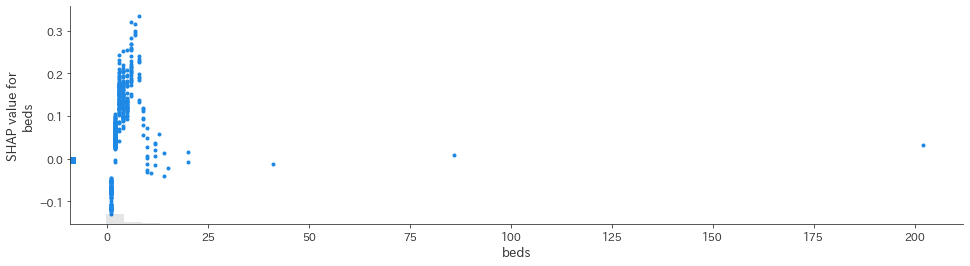

mins


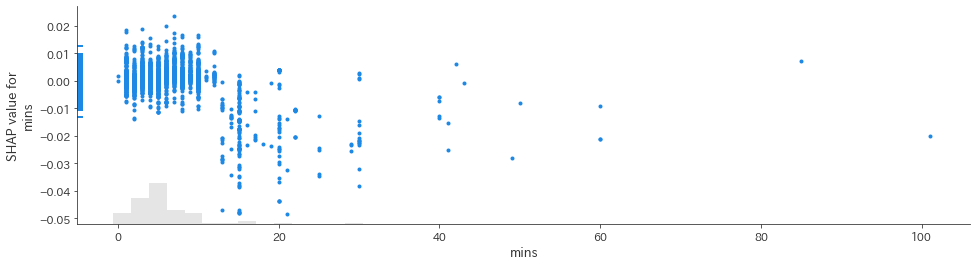

sqm


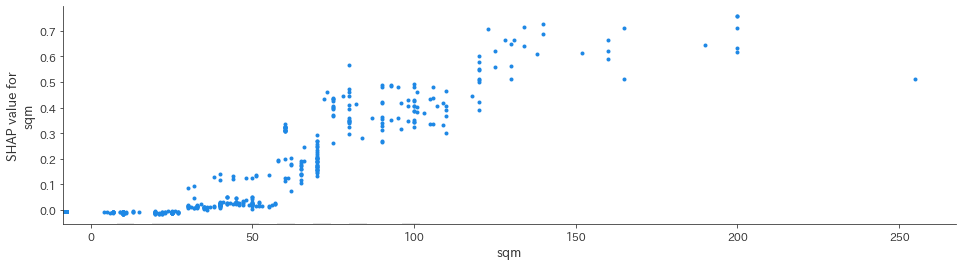

In [22]:
for column in train_x.columns:
    if column.startswith("tfidf_ngram_svd_") or column.startswith("tfidf_word_svd_") or column.startswith("sta_s_pca_"):
        continue
    print(column)
    fig = plt.figure(figsize = (16, 4))
    ax = fig.add_subplot()
    shap.plots.scatter(shap_values[:, column], ax = ax)
    fig.tight_layout()